# What makes you pay higher interest rates on loans?
## by Ivan Ramos

## Investigation Overview

> This investigation aimes to describe interest rate in dataset offered by Prosper Funding LLC, a finantial company   dedicated to deliver personal loans according to people´s credit profiles. 

## Dataset Overview

> Dataset contains around 114,000 registered loans in the US and more than 80 variables for each one within a period of November, 2005 - March, 2014. Dataset is filtered for loans from July, 2009 - March, 2014 because only those entries are formally qualified with an score.
Given the complexity of analysis, this investigation only focuses in a small subset of variables. 

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

> Load curated data and perform additional wrangling

In [119]:
# load in the dataset into a pandas dataframe
loans = pd.read_csv('curated_loans.csv', index_col='LoanKey')

# ratings as categorical ordinal
ratings_list = ['HR', 'E', 'D', 'C', 'B', 'A', 'AA']
ratings_categories = pd.api.types.CategoricalDtype(categories=ratings_list, ordered=True)
loans.ProsperRating = loans.ProsperRating.astype(ratings_categories)

# Add categoriacal ordinal type
income_list = ['$1-24,999',
               '$25,000-49,999',
               '$50,000-74,999',
               '$75,000-99,999',
               '$100,000+']
income_categories = pd.api.types.CategoricalDtype(categories=income_list, ordered=True)
loans.IncomeRange = loans.IncomeRange.astype(income_categories)

## Distribution of interest rates

> Distribution seems to align to a normal one with wide range from rates of 4% up to 35%. 
Main curve peak is placed around 15%, but surprisingly there is another one even higher around 32%. This could represent a standard interest rate in loan products.

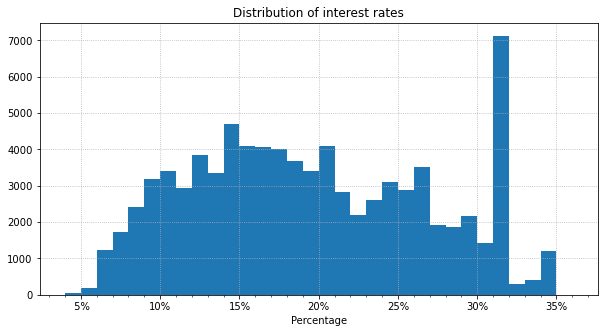

In [69]:
plt.figure(figsize=[10,5])
ax = plt.gca()
rate_bins = np.arange(loans.BorrowerRate.min(), loans.BorrowerRate.max() + 0.01, 0.01)
rate_ticks = np.arange(0.05, loans.BorrowerRate.max() + 0.01, 0.05)
rate_labels = ["{:2.0f}%".format(x*100) for x in rate_ticks]
plt.hist(data=loans, x='BorrowerRate', bins=rate_bins)
ax.xaxis.set_major_locator(MultipleLocator(0.05))
ax.xaxis.set_minor_locator(MultipleLocator(0.01))
plt.title('Distribution of interest rates')
plt.xticks(rate_ticks, rate_labels)
plt.xlabel('Percentage');
ax.grid(linestyle=':', linewidth='0.8')
plt.show()

## Interest rate vs Prosper qualifications

> Prosper Funding LLC usually classifies loans using 2 metrics.
**Prosper score** is a custom risk score built using historical Prosper data. The score ranges from 1-11, with 11 being the best, or lowest risk score. 
**Prosper Rating**, an overall rating that takes into account borrower financial behavior and qualifications go from "HR" as worse to "AA" as the best. This is the distribution of how loans get classified according to above qualifications. We can see how distributions get enlarged towards lower rates as the qualifications get better scored. This is particularly obvious for Prosper Rating.

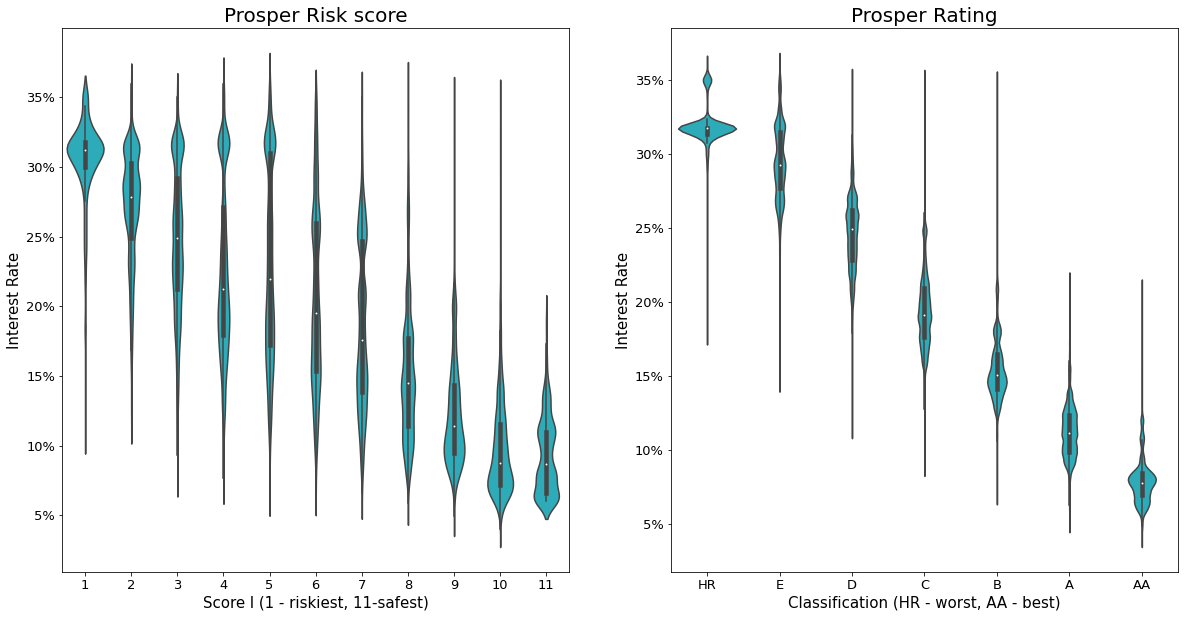

In [166]:
plt.figure(figsize=[20,10])

plt.subplot(1, 2, 1)
base_color = sb.color_palette()[9]
sb.violinplot(x='ProsperScore', y='BorrowerRate', data=loans, color=base_color);
plt.title("Prosper Risk score", size=20)
plt.xlabel("Score l (1 - riskiest, 11-safest)", size=15)
plt.ylabel("Interest Rate", size=15)
plt.xticks(size=13)
plt.yticks(rate_ticks, rate_labels, size=13)

plt.subplot(1, 2, 2)
sb.violinplot(x='ProsperRating', y='BorrowerRate', data=loans, color=base_color);
plt.title("Prosper Rating", size=20)
plt.xlabel("Classification (HR - worst, AA - best)", size=15)
plt.ylabel("Interest Rate", size=15)
plt.xticks(size=13)
plt.yticks(rate_ticks, rate_labels, size=13);


## Interest rate by loan amount

**Nominal interest** rate refers to the interest rate before taking inflation into account. Can also refer to the advertised or stated interest rate on a loan. 

**APR interest** is expressed as a percentage that represents the actual yearly cost of funds over the term of a loan or income earned on an investment. This includes any fees or additional costs associated with the transaction.

As a general rule, interest rate tends to drop as loan amount increases. This phenomenon could be explained by several circumstances, e.g. simply by the fact that people with better credit score can access to bigger loans. Also, please note that standard deviation tends to grow with major loans, 20,000+ US, which suggests that major loans tend to be more negotiable taking into account other factors that affects interest rate. For small loan amounts, interest rates tend to be more predictable. This could suggest there are some interest rate standards around them.


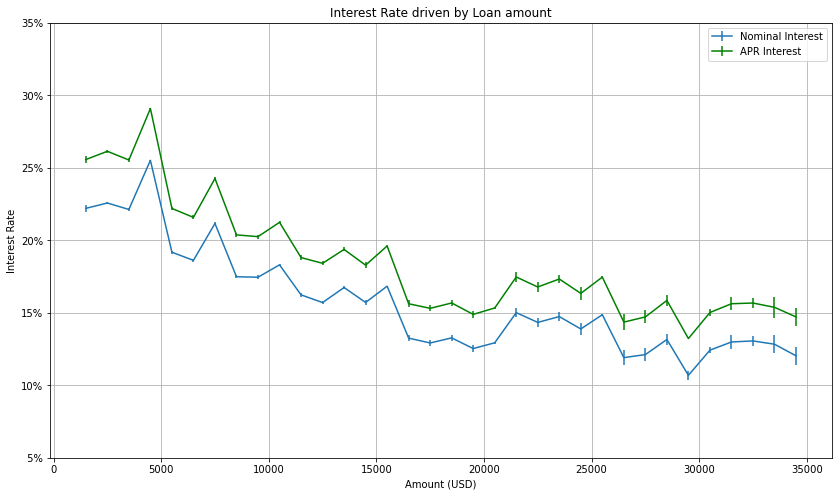

In [116]:
# Calculate centers for loan amount range scale
plt.figure(figsize=[14, 8])
ax = plt.gca()
amount_step = 1000
amount_bins = np.arange(1000, loans.LoanOriginalAmount.max() + amount_step, amount_step)
amount_centers = (amount_bins + amount_step / 2)[:-1]

# Compute means for each
amount_intervals = pd.cut(loans.LoanOriginalAmount, amount_bins, right = False, include_lowest = True)
interest_means = loans['BorrowerRate'].groupby(amount_intervals).mean()
interest_sems = loans['BorrowerRate'].groupby(amount_intervals).sem()

apr_means = loans['BorrowerAPR'].groupby(amount_intervals).mean()
apr_sems = loans['BorrowerAPR'].groupby(amount_intervals).sem()


plt.errorbar(x = amount_centers, y = interest_means, yerr = interest_sems, label="Nominal Interest")
plt.errorbar(x = amount_centers, y = apr_means, yerr = apr_sems, color='g', label="APR Interest")
plt.title("Interest Rate driven by Loan amount")
plt.xlabel('Amount (USD)')
plt.ylabel('Interest Rate')

plt.yticks(rate_ticks, rate_labels)

plt.legend()
ax.grid()

## Income Range and Prosper rating as factors for interest

Distributions of loans based on prosper rating make clear how interest drops as the qualification enhances. Also, notice how as income range increases, quantity of better qualified loans do it as well, and if income decreases, quality of loans decrease.  e.g. number of loans type "D" gradually decrease among income ranges and loans type "AA"  gradually increase until 100,000+ range.

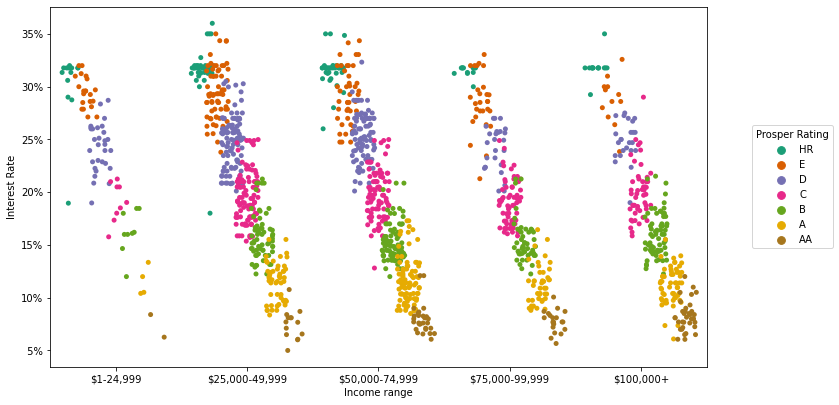

In [156]:
loans_sample = loans.sample(1500, replace=False, random_state=300)
plt.figure(figsize=[11.76, 6.62])
ax = sb.stripplot(data = loans_sample, x = 'IncomeRange', y = 'BorrowerRate', hue = 'ProsperRating',
         jitter = 0.6, dodge = True, palette = "Dark2")
ax.legend(title="Prosper Rating", loc='right',  bbox_to_anchor=(1.2, 0.5))
plt.yticks(rate_ticks, rate_labels)
plt.xlabel("Income range")
plt.ylabel("Interest Rate")
plt.xticks(rotation=0);

### Conclusion

Finance study requires complex interactions. This is a reduced investigation that focused in small amount of variables. As a takeaway, we can conclude that safe low risk investments harvest small safe returns, and with higher risk, then higher returns are expected in inversion´s world.